In [89]:
import rawpy as rw
import numpy as  np
import copy

In [102]:
raw = rw.imread('Images/scene_raw.CR2.dng')

In [16]:
rgb = raw.postprocess()

In [25]:
rgb.shape

(2602, 3906, 3)

In [108]:
raw.raw_image

array([[4095, 4095, 4095, ...,  240, 3855,  240],
       [ 263,  257,  259, ...,  255,  253,  256],
       [ 255,  253,  253, ...,  258,  272,  265],
       ...,
       [ 257,  257,  252, ...,  287,  313,  295],
       [ 135,  200,  136, ...,  197,  121,  196],
       [   1,  245,    1, ...,  250,    1,  246]], dtype=uint16)

In [109]:
raw.raw_colors

array([[0, 1, 0, ..., 1, 0, 1],
       [3, 2, 3, ..., 2, 3, 2],
       [0, 1, 0, ..., 1, 0, 1],
       ...,
       [3, 2, 3, ..., 2, 3, 2],
       [0, 1, 0, ..., 1, 0, 1],
       [3, 2, 3, ..., 2, 3, 2]], dtype=uint8)

In [110]:
def extract_rgb(raw_image, raw_colors):
    
    image_rgb = []
    
    for color in range(4):
        mask = raw_colors != color
        image = raw_image.copy()
        image[mask] = 0
        image_rgb.append(image)
        
    return image_rgb

In [111]:
image_rgb = extract_rgb(raw.raw_image, raw.raw_colors)

In [112]:
image_rgb[0]

array([[4095,    0, 4095, ...,    0, 3855,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [ 255,    0,  253, ...,    0,  272,    0],
       ...,
       [   0,    0,    0, ...,    0,    0,    0],
       [ 135,    0,  136, ...,    0,  121,    0],
       [   0,    0,    0, ...,    0,    0,    0]], dtype=uint16)

In [113]:
image_rgb[1]

array([[   0, 4095,    0, ...,  240,    0,  240],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,  253,    0, ...,  258,    0,  265],
       ...,
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,  200,    0, ...,  197,    0,  196],
       [   0,    0,    0, ...,    0,    0,    0]], dtype=uint16)

In [114]:
image_rgb[2]

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0, 257,   0, ..., 255,   0, 256],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0, 257,   0, ..., 287,   0, 295],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0, 245,   0, ..., 250,   0, 246]], dtype=uint16)

In [115]:
image_rgb[3]

array([[  0,   0,   0, ...,   0,   0,   0],
       [263,   0, 259, ...,   0, 253,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [257,   0, 252, ...,   0, 313,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  1,   0,   1, ...,   0,   1,   0]], dtype=uint16)

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

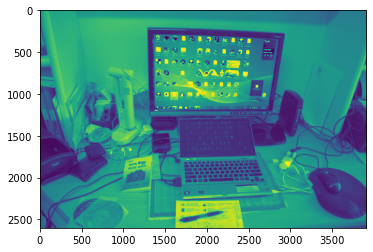

In [23]:
plt.imshow(rgb[:,:,0]);